In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual WordNet
nltk.download('averaged_perceptron_tagger_eng')  # For POS tagging (optional but recommended)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nisa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nisa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Nisa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
# Load the data
data = pd.read_csv('../data/bugs_cleaned.csv')
print(f"Columns: {data.shape[1]}")
print(f"Shape: {data.shape}")
data.head()

Columns: 18
Shape: (9999, 18)


,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category
0,BUGZILLA-294734,2005-05-18,Bugzilla-General,BUGZILLA,Emergency 2.16.10 Release,2.16.9 is broken -- many users can't enter bug...,mkanat,mkanat,fixed,1,resolved,4,2005-05-19,0,15,2005-05-19,1,blocker
1,OTHER_APPLICATIONS-363323,2006-12-09,DOM Inspector,OTHER_APPLICATIONS,DOM View is really inefficient with setting wh...,From comment in url:\n\nCurrent code:\nmenuite...,sdwilsh,sdwilsh,fixed,1,resolved,4,2011-06-01,0,8,2007-01-14,36,normal
2,SUPPORT.MOZILLA.ORG-398246,2007-10-02,General,SUPPORT.MOZILLA.ORG,Add support for custom cookies and cache headers,Adding support for custom headers and cookie n...,morgamic,morgamic,fixed,1,resolved,4,2009-11-02,0,23,2008-03-24,174,blocker
3,RELEASE_ENGINEERING-525991,2009-11-02,General,RELEASE_ENGINEERING,Create Major Update from 3.0.15 to 3.5.5,NaN,catlee,catlee,fixed,1,resolved,4,2013-08-12,0,7,2009-11-10,8,normal
4,OTHER_APPLICATIONS-318859,2005-12-02,ChatZilla,OTHER_APPLICATIONS,DCC functionality in ChatZilla isn't functional.,User-Agent: Mozilla/5.0 (Macintosh U PPC...,gijskruitbosch+bugs,dafydd,fixed,1,resolved,4,2006-02-10,0,14,2005-12-07,5,normal


In [4]:
# Verify missing values
print("Missing values:")
data.isnull().sum()

Missing values:


bug_id                   0
creation_date            0
component_name           0
product_name             0
short_description        1
long_description        79
assignee_name            0
reporter_name            0
resolution_category      0
resolution_code          0
status_category          0
status_code              0
update_date              0
quantity_of_votes        0
quantity_of_comments     0
resolution_date          0
bug_fix_time             0
severity_category        0
dtype: int64

In [5]:
# Check duplicate data
data.duplicated(subset = ['short_description', 'long_description']).sum()

np.int64(2)

In [6]:
# Check duplicated data
data[data.duplicated(subset = ['short_description', 'long_description'])].iloc[:2]

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category
7906,MOZILLA_LOCALIZATIONS-427789,2008-04-08,kn / Kannada,MOZILLA_LOCALIZATIONS,dialog.style in customizeToolbar.properties sh...,In your locale this entity in customizeToolbar...,nobody,marcoos+bmo,fixed,1,resolved,4,2008-04-09,0,4,2008-04-09,1,normal
9095,MOZILLA_LOCALIZATIONS-427788,2008-04-08,ku / Kurdish,MOZILLA_LOCALIZATIONS,dialog.style in customizeToolbar.properties sh...,In your locale this entity in customizeToolbar...,nobody,marcoos+bmo,fixed,1,resolved,4,2008-04-09,0,4,2008-04-09,1,normal


In [7]:
# Since the component_name columns have different values in the duplicated table, 
# I think I can leave it as it is
# Ok, let's check deeper the missing value at the short_description and long_description

# Check the row with empty value/zero or more spaces/empty string on the short_description
short_conditional = data['short_description'].isna() | data['short_description'].str.contains(r'^\s*$', na=False) | (data['short_description'] == '')
data[short_conditional]

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category
7972,CORE-246857,2004-06-15,SVG,CORE,NaN,,tor,tor,fixed,1,resolved,4,2004-06-23,0,4,2004-06-23,8,normal


In [8]:
# Get the index
short_conditional_index = data[short_conditional].index.tolist()
print(short_conditional_index)

[7972]


In [9]:
# Check rows with empty value/zero or more spaces/empty string on the long_description
long_conditional = data['long_description'].isna() | data['long_description'].str.contains(r'^\s*$', na=False) | (data['long_description'] == '')
data[long_conditional]

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category
3,RELEASE_ENGINEERING-525991,2009-11-02,General,RELEASE_ENGINEERING,Create Major Update from 3.0.15 to 3.5.5,NaN,catlee,catlee,fixed,1,resolved,4,2013-08-12,0,7,2009-11-10,8,normal
136,CORE-79680,2001-05-09,Layout: Text and Fonts,CORE,need to land bidi addition string Index: xpfe/...,,ftang,ftang,fixed,1,resolved,4,2008-07-31,0,8,2001-05-11,2,normal
234,CORE-416813,2008-02-11,JavaScript Engine,CORE,jslock.c does not link on VC7.1 due to use of ...,,brendan,longsonr,fixed,1,resolved,4,2008-02-13,0,8,2008-02-13,2,normal
292,CORE-351628,2006-09-06,Layout: Tables,CORE,[reflow branch] Crash [@ nsTableColFrame::Rese...,,nobody,jruderman,fixed,1,resolved,4,2011-06-09,0,19,2006-09-25,19,critical
363,TESTING_GRAVEYARD-483434,2009-03-14,Sisyphus,TESTING_GRAVEYARD,add support for js narcissus,NaN,bob,bob,fixed,1,resolved,4,2019-01-08,0,3,2009-03-14,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,MOZILLA.ORG_GRAVEYARD-450282,2008-08-12,Server Operations,MOZILLA.ORG_GRAVEYARD,Rename tellrob@gmail.com account to robarnold@...,,aravind,tellrob,fixed,1,resolved,4,2015-03-12,0,2,2008-08-12,0,normal
9600,MINIMO_GRAVEYARD-317055,2005-11-18,Minimo Front-End,MINIMO_GRAVEYARD,Favicons in Tabbrowser not working.,,mgalli,mgalli,fixed,1,resolved,4,2005-11-18,0,2,2005-11-18,0,normal
9670,SEAMONKEY-172669,2002-10-04,General,SEAMONKEY,Textfield needs a bit of padding in Windows XP...,,hyatt,hyatt,fixed,1,resolved,4,2009-01-20,0,6,2009-01-20,2300,normal
9702,CORE-328348,2006-02-23,SVG,CORE,Single version of viewport transform code,,tor,tor,fixed,1,resolved,4,2006-02-26,0,7,2006-02-26,3,normal


In [10]:
# Get the index
long_conditional_index = data[long_conditional].index.tolist()
print(long_conditional_index)

[3, 136, 234, 292, 363, 379, 392, 393, 457, 501, 526, 534, 646, 649, 664, 833, 895, 904, 969, 971, 977, 1022, 1031, 1125, 1176, 1218, 1227, 1228, 1254, 1268, 1341, 1595, 1697, 1819, 1836, 1873, 1889, 1952, 2007, 2094, 2098, 2100, 2139, 2154, 2164, 2185, 2197, 2305, 2355, 2391, 2393, 2414, 2592, 2649, 2659, 2790, 2798, 2806, 2834, 2877, 2884, 2911, 2939, 2955, 3061, 3082, 3180, 3197, 3198, 3251, 3273, 3291, 3300, 3322, 3347, 3354, 3384, 3503, 3520, 3538, 3643, 3654, 3659, 3726, 3774, 3851, 3853, 3859, 3920, 3935, 3951, 4051, 4060, 4120, 4131, 4161, 4259, 4299, 4319, 4374, 4500, 4532, 4572, 4622, 4652, 4742, 4776, 4830, 4842, 4987, 5028, 5046, 5051, 5122, 5138, 5234, 5356, 5419, 5449, 5545, 5583, 5704, 5728, 5835, 5935, 5956, 6016, 6141, 6153, 6254, 6268, 6308, 6365, 6382, 6386, 6445, 6587, 6624, 6698, 6721, 6764, 6769, 6787, 6802, 6856, 6865, 6928, 6970, 7033, 7064, 7132, 7167, 7215, 7226, 7262, 7286, 7334, 7343, 7377, 7403, 7404, 7489, 7509, 7597, 7694, 7761, 7763, 7782, 7869, 7913, 79

In [11]:
# Check if there are rows with empty values in both long_description and short_description
both_empty_description_index = list(set(short_conditional_index) & set(long_conditional_index))
print(both_empty_description_index)

[7972]


In [12]:
# Then, I'll drop the row with the index
data_cleaned = data.drop(both_empty_description_index[0])
data_cleaned

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category
0,BUGZILLA-294734,2005-05-18,Bugzilla-General,BUGZILLA,Emergency 2.16.10 Release,2.16.9 is broken -- many users can't enter bug...,mkanat,mkanat,fixed,1,resolved,4,2005-05-19,0,15,2005-05-19,1,blocker
1,OTHER_APPLICATIONS-363323,2006-12-09,DOM Inspector,OTHER_APPLICATIONS,DOM View is really inefficient with setting wh...,From comment in url:\n\nCurrent code:\nmenuite...,sdwilsh,sdwilsh,fixed,1,resolved,4,2011-06-01,0,8,2007-01-14,36,normal
2,SUPPORT.MOZILLA.ORG-398246,2007-10-02,General,SUPPORT.MOZILLA.ORG,Add support for custom cookies and cache headers,Adding support for custom headers and cookie n...,morgamic,morgamic,fixed,1,resolved,4,2009-11-02,0,23,2008-03-24,174,blocker
3,RELEASE_ENGINEERING-525991,2009-11-02,General,RELEASE_ENGINEERING,Create Major Update from 3.0.15 to 3.5.5,NaN,catlee,catlee,fixed,1,resolved,4,2013-08-12,0,7,2009-11-10,8,normal
4,OTHER_APPLICATIONS-318859,2005-12-02,ChatZilla,OTHER_APPLICATIONS,DCC functionality in ChatZilla isn't functional.,User-Agent: Mozilla/5.0 (Macintosh U PPC...,gijskruitbosch+bugs,dafydd,fixed,1,resolved,4,2006-02-10,0,14,2005-12-07,5,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,WWW.MOZILLA.ORG-485595,2009-03-27,General,WWW.MOZILLA.ORG,Firefox 2.0. - 2.0.0.20 update/what's new page...,User-Agent: Mozilla/5.0 (Windows U Windo...,nobody,domthedude001,fixed,1,resolved,4,2012-08-23,0,15,2010-12-27,640,trivial
9995,CORE-132278,2002-03-20,XPCOM,CORE,|nsCOMPtr::operator&()| has outlived its usefu...,We originally made |operator&| illegal to ease...,scc,scc,fixed,1,resolved,4,2003-01-16,0,10,2002-03-28,8,normal
9996,FIREFOX_BUILD_SYSTEM-389793,2007-07-26,General,FIREFOX_BUILD_SYSTEM,Firefox build failed on OpenSolaris without --...,gmake[6]: Entering directory `/export/home/mrb...,ginnchen+exoracle,ginnchen+exoracle,fixed,1,resolved,4,2018-03-02,0,15,2007-08-05,10,normal
9997,MOZILLA_LOCALIZATIONS-402568,2007-11-05,fy-NL / Frisian,MOZILLA_LOCALIZATIONS,language pack fails to install due to broken i...,The files \n l10n/fy-NL/browser/defines.inc\n...,fryskefirefox,nthomas,fixed,1,resolved,4,2009-11-27,0,3,2009-11-27,753,normal


In [13]:
# Before I clean the text data, I will combine those two columns first
# (and I will fill null values at the long_description column with an empty string)

data_cleaned['text_combined'] = data_cleaned['short_description'] + ' ' + data_cleaned['long_description'].fillna('')
data_cleaned['text_combined']

0       Emergency 2.16.10 Release 2.16.9 is broken -- ...
1       DOM View is really inefficient with setting wh...
2       Add support for custom cookies and cache heade...
3               Create Major Update from 3.0.15 to 3.5.5 
4       DCC functionality in ChatZilla isn't functiona...
                              ...                        
9994    Firefox 2.0. - 2.0.0.20 update/what's new page...
9995    |nsCOMPtr::operator&()| has outlived its usefu...
9996    Firefox build failed on OpenSolaris without --...
9997    language pack fails to install due to broken i...
9998    In  4 Warning: anonymous function does not alw...
Name: text_combined, Length: 9998, dtype: object

In [14]:
# lower all text data
text_combined_lower = data_cleaned['text_combined'].str.lower()
text_combined_lower

0       emergency 2.16.10 release 2.16.9 is broken -- ...
1       dom view is really inefficient with setting wh...
2       add support for custom cookies and cache heade...
3               create major update from 3.0.15 to 3.5.5 
4       dcc functionality in chatzilla isn't functiona...
                              ...                        
9994    firefox 2.0. - 2.0.0.20 update/what's new page...
9995    |nscomptr::operator&()| has outlived its usefu...
9996    firefox build failed on opensolaris without --...
9997    language pack fails to install due to broken i...
9998    in  4 warning: anonymous function does not alw...
Name: text_combined, Length: 9998, dtype: object

In [15]:
# remove special characters and split the words
text_tokens = text_combined_lower.str.replace(r'[^a-z\s]','', regex=True).str.split()
text_tokens

0       [emergency, release, is, broken, many, users, ...
1       [dom, view, is, really, inefficient, with, set...
2       [add, support, for, custom, cookies, and, cach...
3                       [create, major, update, from, to]
4       [dcc, functionality, in, chatzilla, isnt, func...
                              ...                        
9994    [firefox, updatewhats, new, pages, outdated, u...
9995    [nscomptroperator, has, outlived, its, usefull...
9996    [firefox, build, failed, on, opensolaris, with...
9997    [language, pack, fails, to, install, due, to, ...
9998    [in, warning, anonymous, function, does, not, ...
Name: text_combined, Length: 9998, dtype: object

In [16]:
# Word frequency analysis
# Overall word frequency
all_words = [word for tokens in text_tokens for word in tokens]
word_freq_raw = Counter(all_words)
print(f"\nTotal unique words: {len(word_freq_raw)}")
print(f"\nTotal words: {len(all_words)}")
print(f"\nTop 20 most common words:")
for word, count in word_freq_raw.most_common(30):
    print(f"{word:15s} : {count:5d}")


Total unique words: 53505

Total words: 841178

Top 20 most common words:
the             : 39829
to              : 23695
a               : 14946
in              : 14893
is              : 12513
and             : 12011
of              :  9925
for             :  8766
this            :  8247
i               :  7948
it              :  7584
on              :  7216
that            :  6902
be              :  6062
not             :  5974
mozilla         :  5645
with            :  5630
windows         :  5281
should          :  4266
bug             :  4144
from            :  4087
as              :  4031
we              :  3876
x               :  3864
if              :  3859
gecko           :  3830
u               :  3776
line            :  3692
at              :  3676
when            :  3618


In [17]:
# Word frequency by severity category
print("Word frequency by severity category (Top 10):")
for severity in data_cleaned['severity_category'].unique():
    severity_mask = data_cleaned['severity_category'] == severity
    severity_words = [word for idx, tokens in text_tokens[severity_mask].items() for word in tokens]
    severity_freq = Counter(severity_words)
    print(f"\n{severity.upper()} (n={severity_mask.sum()}):")
    for word, count in severity_freq.most_common(10):
        print(f"{word:15s} : {count:5d}")

Word frequency by severity category (Top 10):

BLOCKER (n=205):
the             :  1192
is              :   750
corrupt         :   508
smozillawintalkbackzip :   507
archive         :   444
to              :   400
in              :   341
a               :   254
and             :   243
mar             :   217

NORMAL (n=7603):
the             : 29193
to              : 17479
a               : 11041
in              : 10604
and             :  8845
is              :  8785
of              :  7522
for             :  6861
this            :  6155
it              :  5541

MAJOR (n=738):
the             :  3748
to              :  2391
a               :  1327
in              :  1240
is              :  1162
and             :  1129
i               :   919
of              :   848
this            :   803
for             :   783

MINOR (n=541):
the             :  2408
to              :  1358
in              :   884
a               :   860
is              :   797
and             :   720
of             

In [34]:
# Remove stopwords (since so many stopwords there)
stop_words = set(stopwords.words('english'))
print(f"Standard English stopwords: {len(stop_words)}")

# Since there are some special characters in the stopwords
# I will clean those words
cleaned_stop_words = {re.sub(r'[^a-z]','',s) for s in stop_words}

# Custom stopwords
custom_stopwords = {'always','firefox', 'mozilla', 'gecko', 'bugzilla','bug', 'issue', 'error', 'problem', 'http', 'r', 'o', 'O', 'u', 'v', 'x', 'result', 'window', 'windows', 'use', 'uses', 'used', 'build', 'line', 'result', 'results', 'file', 'file', 'enus', 'page'}

print(f"\nCustom domain-specific stopwords being added:")
print(f"  {sorted(custom_stopwords)}")
cleaned_stop_words.update(custom_stopwords)

stop_words.update(custom_stopwords)
print(f"\nTotal stopwords after adding custom: {len(stop_words)}")

Standard English stopwords: 198

Custom domain-specific stopwords being added:
  ['O', 'always', 'bug', 'bugzilla', 'build', 'enus', 'error', 'file', 'firefox', 'gecko', 'http', 'issue', 'line', 'mozilla', 'o', 'page', 'problem', 'r', 'result', 'results', 'u', 'use', 'used', 'uses', 'v', 'window', 'windows', 'x']

Total stopwords after adding custom: 225


In [35]:
# Removal process
text_tokens_no_stop = text_tokens.apply(lambda x: [word for word in x if word not in cleaned_stop_words])

In [36]:
# Word frequency after stopword removal
all_words_no_stop = [word for tokens in text_tokens_no_stop for word in tokens]
word_freq_no_stop = Counter(all_words_no_stop)

print(f"\nAfter stopword removal:")
print(f"Total unique words: {len(word_freq_no_stop)}")
print(f"Total words: {len(all_words_no_stop)}")
print(f"Reduction: {len(all_words) - len(all_words_no_stop)} words removed")
print(f"\nTop 20 most common words (after stopword removal):")
for word, count in word_freq_no_stop.most_common(30):
    print(f"{word:15s} : {count:5d}")


After stopword removal:
Total unique words: 53306
Total words: 470918
Reduction: 370260 words removed

Top 20 most common words (after stopword removal):
nt              :  2203
reproduce       :  2199
steps           :  2179
new             :  2143
useragent       :  2116
reproducible    :  2115
rv              :  2088
identifier      :  1980
expected        :  1735
code            :  1719
actual          :  1646
one             :  1584
get             :  1552
see             :  1532
like            :  1519
need            :  1439
using           :  1403
would           :  1360
patch           :  1295
linux           :  1265
text            :  1261
make            :  1247
created         :  1179
open            :  1152
int             :  1146
test            :  1136
url             :  1131
also            :  1121
click           :  1103
attachment      :  1093


In [37]:
# Helper function to convert NLTK POS tags to WordNet POS tags
# I need this since it can make a lemmatization for verb, noun, etc.

def get_wordnet_pos(treebank_tag):
    """Convert Treebank POS tag to WordNet POS tag"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Advanced lemmatization with POS tagging
def lemmatize_with_pos(tokens):
    """Lemmatize tokens using POS tags for better accuracy"""
    lemmatizer = WordNetLemmatizer()
    
    # Get POS tags
    pos_tags = nltk.pos_tag(tokens)
    
    # Lemmatize with appropriate POS
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
        for word, pos in pos_tags
    ]
    return lemmatized

# Apply advanced lemmatization
text_tokens_lemmatized_pos = text_tokens_no_stop.apply(lemmatize_with_pos)

In [38]:
# Word frequency after lemmatization
all_words_lemmatized = [word for tokens in text_tokens_lemmatized_pos for word in tokens]
word_freq_lemmatized = Counter(all_words_lemmatized)

print(f"\nAfter lemmatization:")
print(f"Total unique words: {len(word_freq_lemmatized)}")
print(f"Total words: {len(all_words_lemmatized)}")
print(f"Reduction: {len(word_freq_no_stop) - len(word_freq_lemmatized)} unique words merged")
print(f"\nTop 20 most common words (after lemmatization):")
for word, count in word_freq_lemmatized.most_common(20):
    print(f"  {word:15s} : {count:5d}")


After lemmatization:
Total unique words: 50800
Total words: 470918
Reduction: 2506 unique words merged

Top 20 most common words (after lemmatization):
  step            :  2345
  get             :  2327
  reproduce       :  2237
  need            :  2225
  nt              :  2204
  new             :  2182
  useragent       :  2116
  reproducible    :  2115
  create          :  2089
  rv              :  2088
  change          :  1993
  identifier      :  1988
  work            :  1982
  make            :  1890
  add             :  1864
  test            :  1859
  expect          :  1837
  see             :  1808
  code            :  1760
  one             :  1686


In [39]:
# Analyze word frequency by severity category
severity_word_freq = {}
severity_totals = {}
for severity in data_cleaned['severity_category'].unique():
    severity_mask = data_cleaned['severity_category'] == severity
    severity_words = [word for idx, tokens in text_tokens_lemmatized_pos[severity_mask].items() for word in tokens]
    severity_word_freq[severity] = Counter(severity_words)
    severity_totals[severity] = len(severity_words)

In [40]:
# Total word number after lemmatized
overall_total = sum(word_freq_lemmatized.values())

In [41]:
# Counting word distribution by severity
print("\nWord distribution by severity:")
for severity in sorted(severity_totals.keys()):
    count = data_cleaned[data_cleaned['severity_category'] == severity].shape[0]
    words = severity_totals[severity]
    avg_words = words / count if count > 0 else 0
    print(f"  {severity:12s}: {count:4d} bugs, {words:6d} total words, {avg_words:.1f} avg words/bug")


Word distribution by severity:
  blocker     :  205 bugs,  11657 total words, 56.9 avg words/bug
  critical    :  606 bugs,  46541 total words, 76.8 avg words/bug
  major       :  738 bugs,  44428 total words, 60.2 avg words/bug
  minor       :  541 bugs,  26443 total words, 48.9 avg words/bug
  normal      : 7603 bugs, 330163 total words, 43.4 avg words/bug
  trivial     :  305 bugs,  11686 total words, 38.3 avg words/bug


In [42]:
# Find distinctive words for each severity
# Find the ratio between words that appear significantly more in a cateory
# and overall
distinctive_results = {}
for severity in sorted(data_cleaned['severity_category'].unique()):
    print(f"\n{severity.upper()}:")

    severity_total = severity_totals[severity]
    distinctive_words = []
    for word, count in severity_word_freq[severity].most_common(100):
        if count >= 5:# Minimum threshold
            # Calculate relative frequency
            severity_ratio = count / severity_total if severity_total > 0 else 0
            overall_ratio = word_freq_lemmatized[word] / overall_total if overall_total > 0 else 0
            distinctiveness = severity_ratio / overall_ratio if overall_ratio > 0 else 0

            # Only include words that are notably more common in this category
            if distinctiveness > 1.5:
                distinctive_words.append((word, count, distinctiveness))
    # Sort by distinctiveness score
    distinctive_words.sort(key = lambda x: x[2], reverse = True)
    distinctive_results[severity] = distinctive_words
    print(f"  Top 15 distinctive words:")
    for i, (word, count, ratio) in enumerate(distinctive_words[:15], 1):
        print(f"    {i:2d}. {word:15s} : count={count:4d}, distinctiveness={ratio:.2f}x")
    
    if len(distinctive_words) == 0:
        print("    (No highly distinctive words found)")
    


BLOCKER:
  Top 15 distinctive words:
     1. smozillawintalkbackzip : count= 507, distinctiveness=40.40x
     2. xffbee          : count=  18, distinctiveness=40.40x
     3. crc             : count=  63, distinctiveness=39.77x
     4. corrupt         : count= 508, distinctiveness=36.19x
     5. mar             : count= 217, distinctiveness=34.51x
     6. archive         : count= 445, distinctiveness=34.44x
     7. err             : count=  21, distinctiveness=27.37x
     8. sun             : count=  51, distinctiveness=22.15x
     9. reading         : count=  27, distinctiveness=21.81x
    10. dbx             : count=  25, distinctiveness=20.61x
    11. successfully    : count=  52, distinctiveness=16.81x
    12. submit          : count=  62, distinctiveness=9.86x
    13. acaddoptions    : count=  20, distinctiveness=6.79x
    14. read            : count=  62, distinctiveness=5.35x
    15. push            : count=  19, distinctiveness=5.15x

CRITICAL:
  Top 15 distinctive words:
     

In [43]:
# Find words that are common across all categories
common_across_all = []
for word in word_freq_lemmatized.most_common(50):
    word_name = word[0]
    # Check if word appears in top 30 of all categories
    appears_in_all = all(
        word_name in [w[0] for w in severity_word_freq[sev].most_common(30)]
        for sev in data_cleaned['severity_category'].unique()
    )
    if appears_in_all:
        common_across_all.append(word_name)
    
print(f"\nWords appearing frequently in all severity categories:")
print(f"(These are candidates for custom stopwords)")
for word in common_across_all[:15]:
    print(f"  - {word}")

# I will re-run script after this


Words appearing frequently in all severity categories:
(These are candidates for custom stopwords)


In [44]:
# Text length analysis and describe the text length statistically
data_cleaned['text_length_raw'] = text_tokens.apply(len)
data_cleaned['text_length_processed'] = text_tokens_lemmatized_pos.apply(len)

print("\nText length by severity category:")
length_stats = data_cleaned.groupby('severity_category')[['text_length_raw', 'text_length_processed']].describe()
print(length_stats)

print("\nText length reduction by preprocessing:")
total_reduction = data_cleaned['text_length_raw'].sum() - data_cleaned['text_length_processed'].sum()
reduction_pct = (total_reduction / data_cleaned['text_length_raw'].sum()) * 100
print(f"Total words removed: {total_reduction} ({reduction_pct:.1f}%)")


Text length by severity category:
                  text_length_raw                                            \
                            count        mean         std  min    25%   50%   
severity_category                                                             
blocker                     205.0   96.770732  212.707594  3.0  33.00  61.0   
critical                    606.0  122.513201  169.428370  4.0  40.25  81.0   
major                       738.0  109.609756  100.375682  6.0  47.25  82.0   
minor                       541.0   89.029575   78.225665  3.0  40.00  67.0   
normal                     7603.0   78.532027   77.481636  1.0  33.00  58.0   
trivial                     305.0   68.724590   61.307327  2.0  28.00  55.0   

                                 text_length_processed                         \
                     75%     max                 count       mean         std   
severity_category                                                               
blocker   

Visualization saved: ../figures/text_analysis_complete.png


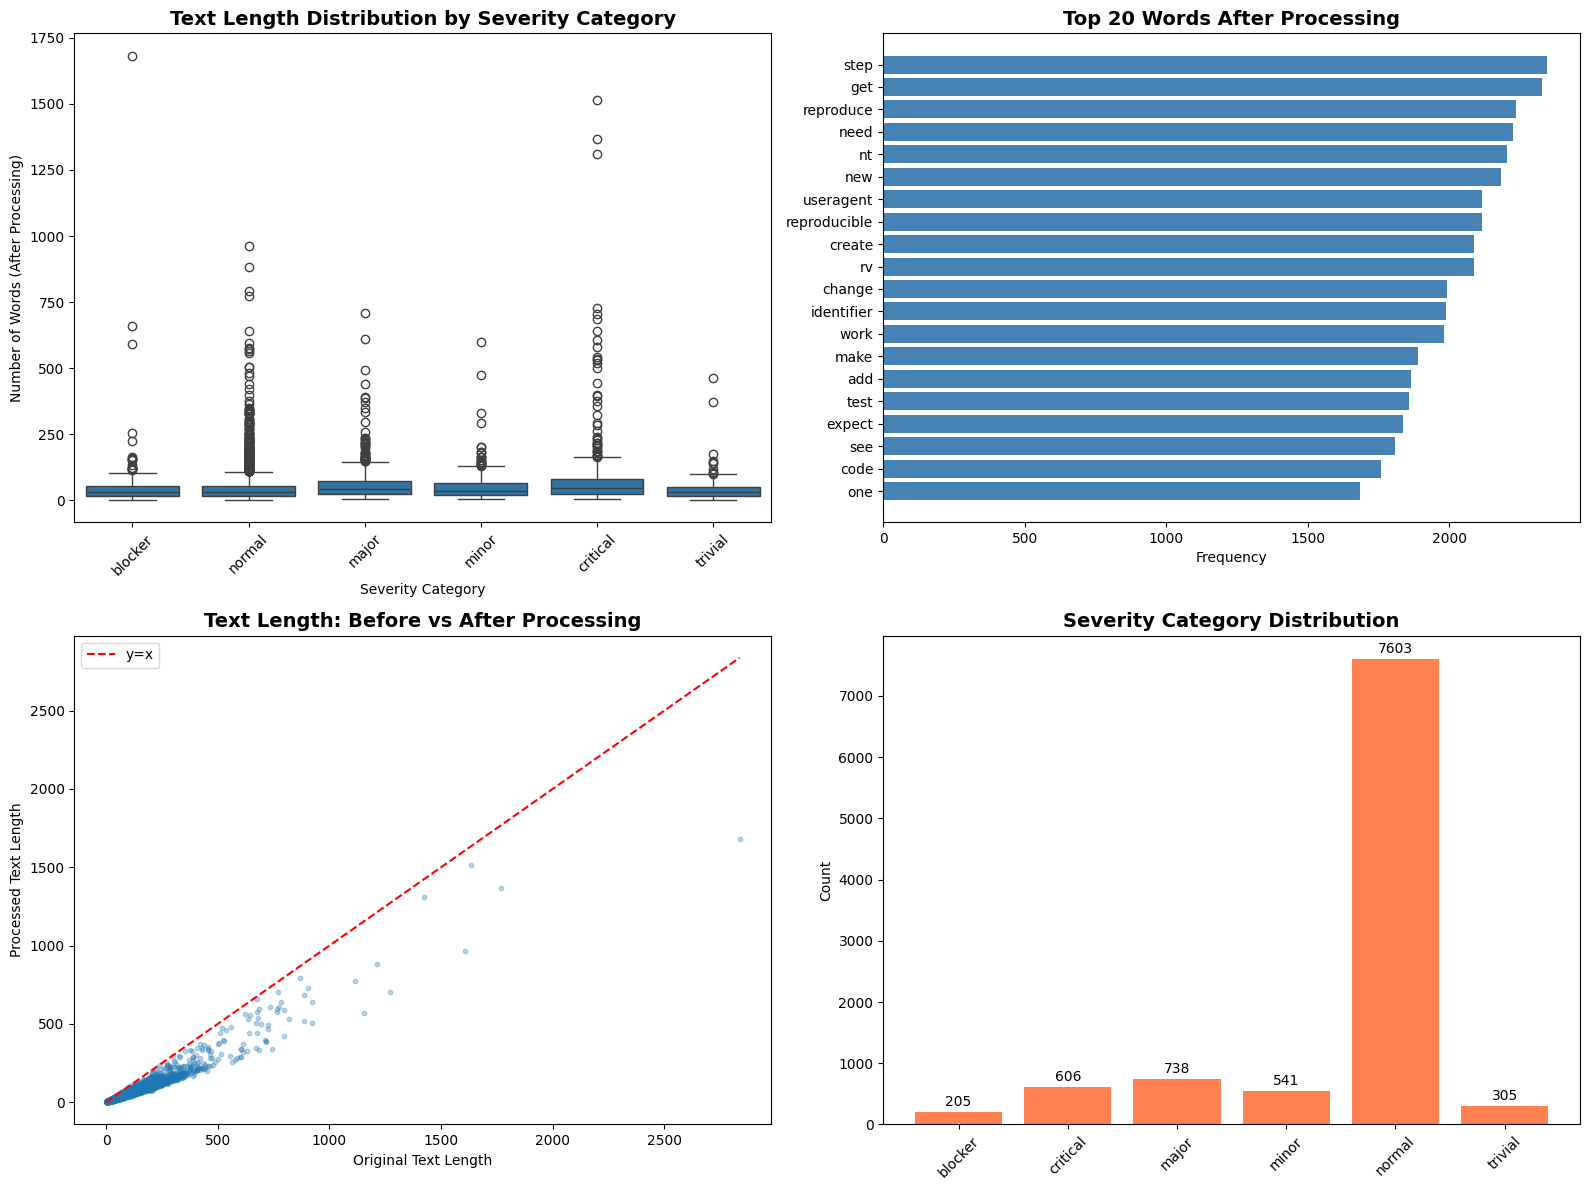

In [45]:
# Make a viz
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Text length distribution by severity
sn.boxplot(data=data_cleaned, x='severity_category', y='text_length_processed', ax=axes[0, 0])
axes[0, 0].set_title('Text Length Distribution by Severity Category', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Severity Category')
axes[0, 0].set_ylabel('Number of Words (After Processing)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Top 20 words (all severities)
top_words = word_freq_lemmatized.most_common(20)
words, counts = zip(*top_words)
axes[0, 1].barh(range(len(words)), counts, color='steelblue')
axes[0, 1].set_yticks(range(len(words)))
axes[0, 1].set_yticklabels(words)
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Top 20 Words After Processing', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Compare text length in raw data and processed data
axes[1, 0].scatter(data_cleaned['text_length_raw'], 
                   data_cleaned['text_length_processed'], 
                   alpha=0.3, s=10)
axes[1, 0].plot([0, data_cleaned['text_length_raw'].max()], 
                [0, data_cleaned['text_length_raw'].max()], 
                'r--', label='y=x')
axes[1, 0].set_xlabel('Original Text Length')
axes[1, 0].set_ylabel('Processed Text Length')
axes[1, 0].set_title('Text Length: Before vs After Processing', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# Severity category distribution
severity_counts = data_cleaned['severity_category'].value_counts().sort_index()
axes[1, 1].bar(range(len(severity_counts)), severity_counts.values, color='coral')
axes[1, 1].set_xticks(range(len(severity_counts)))
axes[1, 1].set_xticklabels(severity_counts.index, rotation=45)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Severity Category Distribution', fontsize=14, fontweight='bold')
# Add count labels on bars
for i, v in enumerate(severity_counts.values):
    axes[1, 1].text(i, v + 50, str(v), ha='center', va='bottom')
    
plt.tight_layout()
plt.savefig('../figures/text_analysis_complete.png', dpi=300, bbox_inches='tight')
print("Visualization saved: ../figures/text_analysis_complete.png")
plt.show()

Visualization saved: ../figures/distinctive_words.png


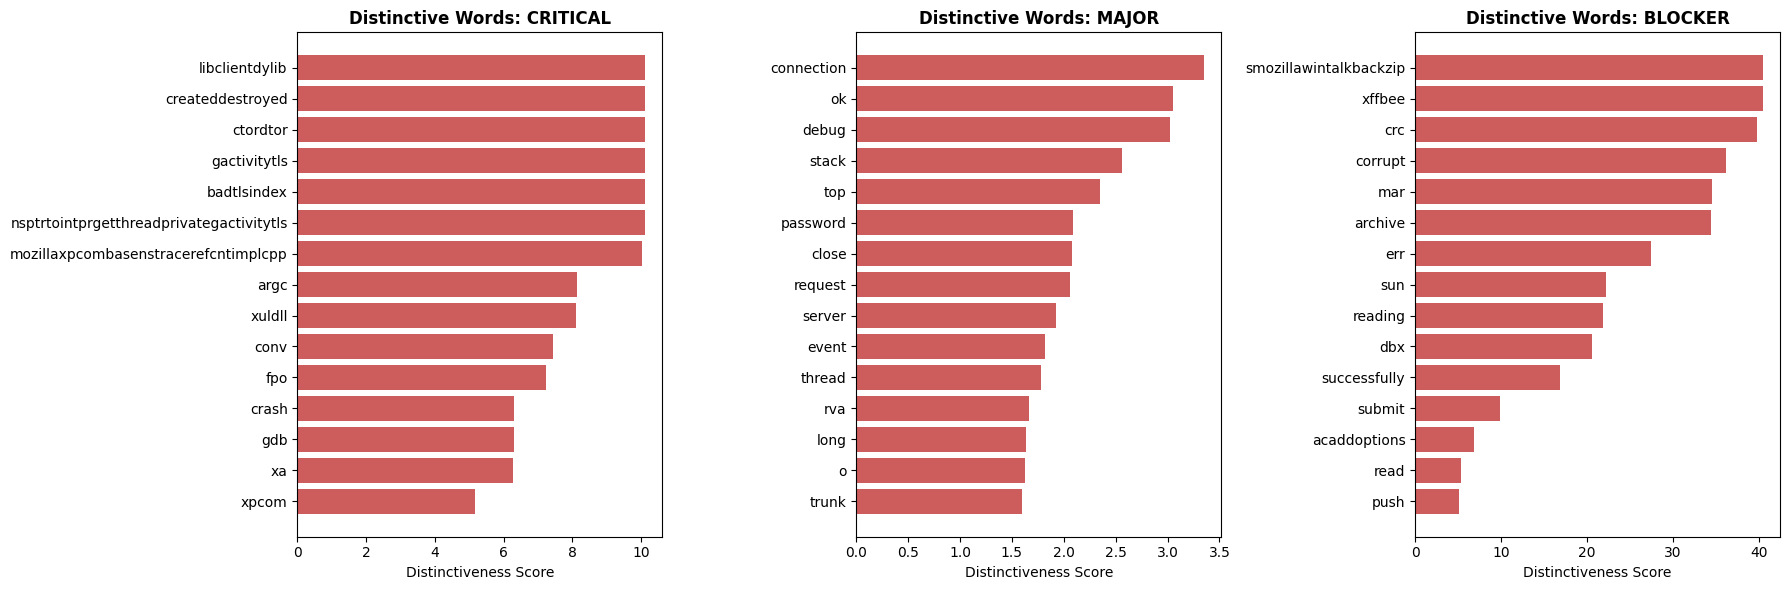

In [49]:
# Additional: Distinctive words visualization for top 3 severities
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))

top_severities = ['critical', 'major', 'blocker']
for idx, severity in enumerate(top_severities):
    if severity in distinctive_results and len(distinctive_results[severity]) > 0:
        top_distinctive = distinctive_results[severity][:15]
        if top_distinctive:
            words_dist, counts_dist, ratios_dist = zip(*top_distinctive)
            
            axes2[idx].barh(range(len(words_dist)), ratios_dist, color='indianred')
            axes2[idx].set_yticks(range(len(words_dist)))
            axes2[idx].set_yticklabels(words_dist)
            axes2[idx].set_xlabel('Distinctiveness Score')
            axes2[idx].set_title(f'Distinctive Words: {severity.upper()}', fontsize=12, fontweight='bold')
            axes2[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('../figures/distinctive_words.png', dpi=300, bbox_inches='tight')
print("Visualization saved: ../figures/distinctive_words.png")
plt.show()

In [50]:
# Save tokens as space-separated strings
data_cleaned['text_processed'] = text_tokens_lemmatized_pos.apply(lambda x: ' '.join(x))

# Save preprocessed data
data_cleaned.to_csv('../data/bugs_preprocessed.csv', index=False)
print(f"Saved preprocessed data: ../data/bugs_preprocessed.csv")
print(f"Shape: {data_cleaned.shape}")
print(f"Columns: {list(data_cleaned.columns)}")

# Save word frequencies for reference
freq_df = pd.DataFrame([
    {'word': word, 'frequency': count, 'rank': idx+1}
    for idx, (word, count) in enumerate(word_freq_lemmatized.most_common(500))
])
freq_df.to_csv('../data/word_frequencies.csv', index=False)
print(f"Saved word frequencies: ../data/word_frequencies.csv")

Saved preprocessed data: ../data/bugs_preprocessed.csv
Shape: (9998, 22)
Columns: ['bug_id', 'creation_date', 'component_name', 'product_name', 'short_description', 'long_description', 'assignee_name', 'reporter_name', 'resolution_category', 'resolution_code', 'status_category', 'status_code', 'update_date', 'quantity_of_votes', 'quantity_of_comments', 'resolution_date', 'bug_fix_time', 'severity_category', 'text_combined', 'text_length_raw', 'text_length_processed', 'text_processed']
Saved word frequencies: ../data/word_frequencies.csv


In [51]:
# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("WEEK 2 TEXT PREPROCESSING - COMPLETE!")
print("="*60)
print("\nSummary:")
print(f"  • Original data: {data_cleaned.shape[0]+1} rows")
print(f"  • After cleaning: {data_cleaned.shape[0]} rows")
print(f"  • Total unique words (raw): {len(word_freq_raw)}")
print(f"  • After stopword removal: {len(word_freq_no_stop)}")
print(f"  • After lemmatization: {len(word_freq_lemmatized)}")
print(f"  • Custom stopwords added: {len(custom_stopwords)}")
print(f"  • Word reduction: {len(word_freq_raw) - len(word_freq_lemmatized)} ({((len(word_freq_raw) - len(word_freq_lemmatized))/len(word_freq_raw)*100):.1f}%)")

print("\nOutput files:")
print("  ✓ ../data/bugs_preprocessed.csv")
print("  ✓ ../data/word_frequencies.csv")
print("  ✓ ../figures/text_analysis_complete.png")
print("  ✓ ../figures/distinctive_words.png")


WEEK 2 TEXT PREPROCESSING - COMPLETE!

Summary:
  • Original data: 9999 rows
  • After cleaning: 9998 rows
  • Total unique words (raw): 53505
  • After stopword removal: 53306
  • After lemmatization: 50800
  • Custom stopwords added: 28
  • Word reduction: 2705 (5.1%)

Output files:
  ✓ ../data/bugs_preprocessed.csv
  ✓ ../data/word_frequencies.csv
  ✓ ../figures/text_analysis_complete.png
  ✓ ../figures/distinctive_words.png
